
# Purpose of Notebook

The goal of this code is to investigate deep mixing with Red Giants.
- The mass used will be generated using a Random Forest Model

The steps that will need to be taken in order to investigate deep mixing
1.  Compute Carbon to Nitrogen Ratio for Red Giants $$ \Big[\frac{C}{N}\Big] = \Big[\frac{C}{Fe}\Big] - \Big[\frac{N}{Fe}\Big] $$
2.  Determine which stars are Red Giants
    - To achieve this, we will need to graph `log(g)` vs `teff` to create a HR diagram
    - Using the HR diagram, we will then determine the Red Giants

3.  Separate Stars into _**need help with this**_

## Expected Results
We should see the deep mixing decreases as a function of mass and metallicity.
- Which of the two factors are more significant remains to be seen.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [35]:
apogee = pd.read_csv("ProcessedData/apogee_with_mass.csv")

# 1. Compute Relative Abundance of Carbon to Nitrogen

In [36]:
apogee["c_n"] = apogee.c_fe - apogee.n_fe
apogee.columns

Index(['tmass_id', 'teff', 'logg', 'fe_h', 'al_fe', 'c_fe', 'n_fe', 'o_fe',
       'mass', 'c_n'],
      dtype='object')

In [37]:
apogee.c_n

0        -0.766240
1        -0.109907
2        -0.312257
3        -0.526230
4        -0.133700
            ...   
401083   -0.057909
401084   -0.188439
401085   -0.344606
401086   -0.262194
401087   -0.220958
Name: c_n, Length: 401088, dtype: float64

# 2. Find the !(Blue Midgets)

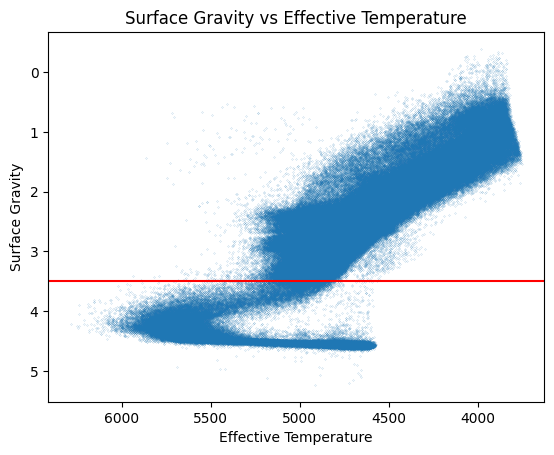

In [38]:
figure = plt.plot(
    apogee.teff,
    apogee.logg,
    '.',
    markersize=0.2,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Effective Temperature")
# The Cutoff is round
plt.axhline(y=3.5, color='r', linestyle='-')

Text(0.5, 1.0, 'Surface Gravity vs Log Effective Temperature')

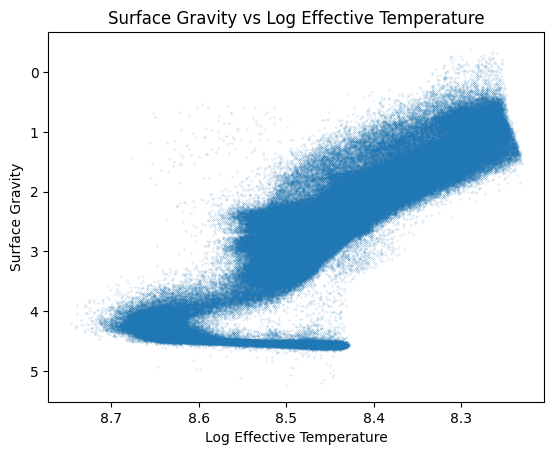

In [39]:
plt.plot(
    np.log(apogee.teff),
    apogee.logg,
    '.',
    markersize=0.2,
)
plt.plot()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Log Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Log Effective Temperature")
# No significant difference so this will be ignored.

Based on the analysis above, the ideal cutoff for red giants is for `log g > 3.5`.

In [40]:
red_giants_apogee = apogee.query("logg < 3.5")
red_giants_apogee.to_csv("ProcessedData/apogee_red_giant.csv", index=False)

In [41]:
red_giants_apogee = pd.read_csv("ProcessedData/apogee_red_giant.csv")

# 3. Investigate Deep Mixing as a function of Mass and Metallicity.


Separate Data into 25 Groups, which is determined by the metallicity and mass.
- Separate Mass like so:
$$ 0.5 \leq \frac{M}{M_\odot} < 1 , 1 \leq \frac{M}{M_\odot} < 1.25,  1.25 \leq \frac{M}{M_\odot} < 1.50, 1.50 \leq \frac{M}{M_\odot} < 2.2 ,\frac{M}{M_\odot} \geq 2.2 $$

- Separate Metallicity like so:
$$ 0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.25$, -0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.75$, -0.75 \geq \Big[\frac{Fe}{H}\Big] > -1.25$, -1.25 \geq \Big[\frac{Fe}{H}\Big] > -1.75$, -1.75 \geq \Big[\frac{Fe}{H}\Big] > -4 $$


In [85]:
fe_h_range = [0.25, -0.25, -0.75, -1.25, -1.75, -4]
mass_range = [0.5, 1, 1.25, 1.5, 2.2, 4.0]
# Approximate position of RGBb
rgbbedge = [[2.666, 2.661, 2.654, 2.587, 2.50],
            [2.509, 2.500, 2.432, 2.456, 2.4],
            [2.301, 2.277, 2.222, 2.186, 2.1],
            [2.106, 2.060, 2.036, 2.098, 2.0],
            [1.953, 1.895, 1.881, 1.846, 1.8]]

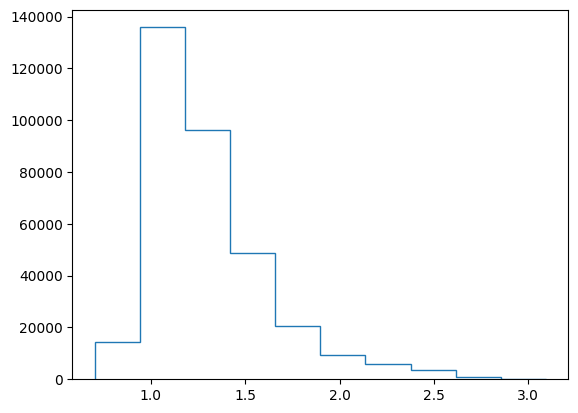

In [65]:
red_giants_apogee.mass.describe()
counts, bins = np.histogram(red_giants_apogee.mass)
plt.stairs(counts, bins)

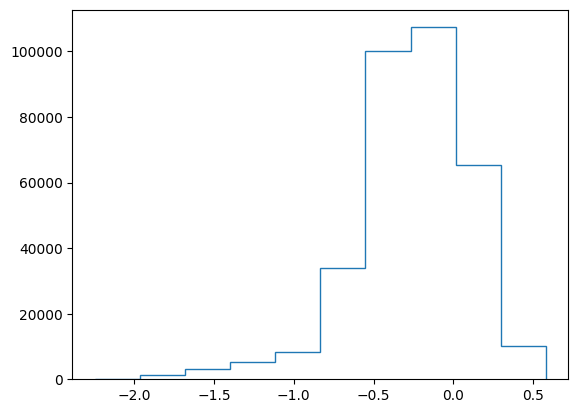

In [66]:
red_giants_apogee.fe_h.describe()
counts, bins = np.histogram(red_giants_apogee.fe_h)
plt.stairs(counts, bins)

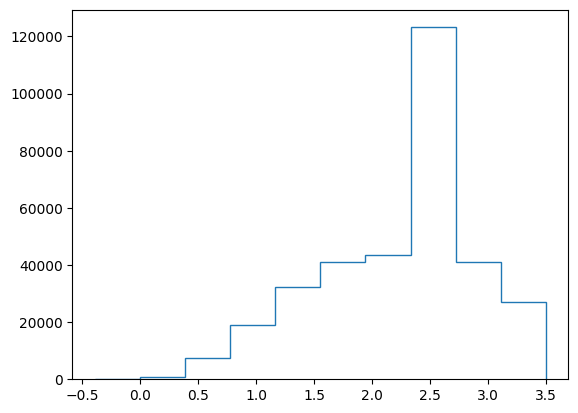

In [67]:
red_giants_apogee.logg.describe()
counts, bins = np.histogram(red_giants_apogee.logg)
plt.stairs(counts, bins)

In [68]:
# Code taken from Chris's Honours
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                 np.arange(npt),
                 np.sort(x))

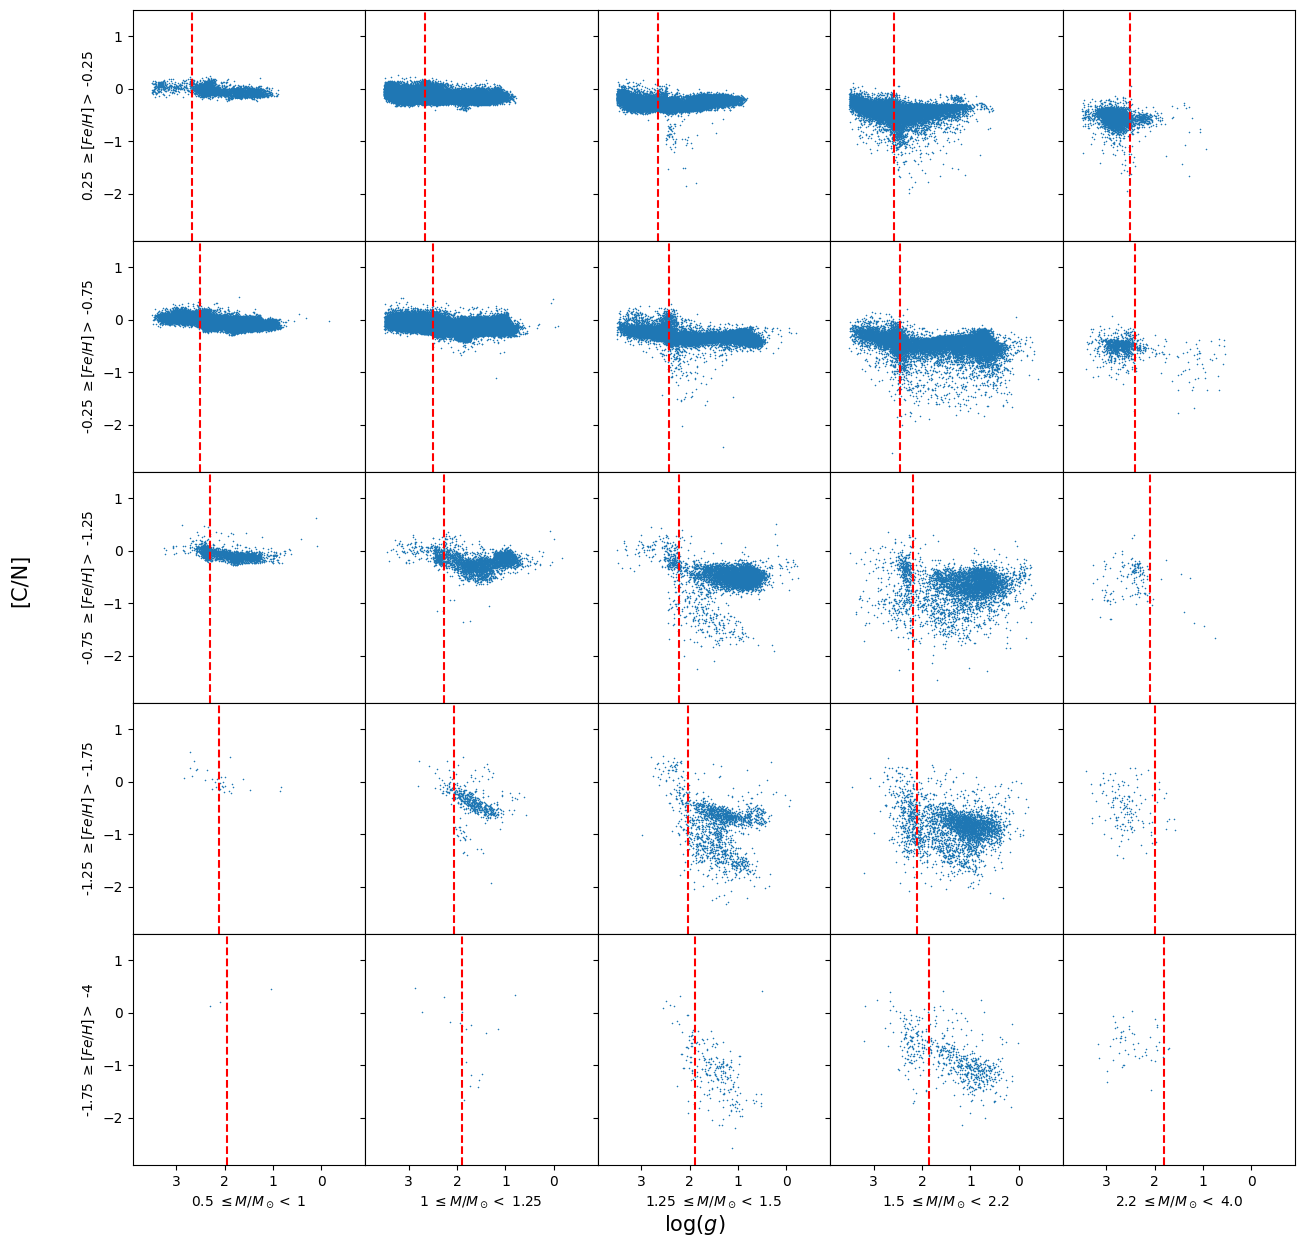

In [88]:
figure, axis = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=(15, 15),
    sharex=True,
    sharey=True
)

figure.subplots_adjust(hspace=0)
figure.subplots_adjust(wspace=0)
figure.text(0.5, 0.07, "$\log(g)$", ha="center", va="center", fontsize=15)
figure.text(0.05, 0.5, "[C/N]", ha="center", va="center", rotation="vertical",fontsize=15)
plt.axis([3.9, -0.9, -2.9, 1.5])

# Populate each part of the graph
for i in range(0, 5): # Iterate over metallicity
    for j in range(0, 5): # Iterate over mass
        bin = red_giants_apogee[
            (red_giants_apogee.mass >= mass_range[j]) & (red_giants_apogee.mass < mass_range[j + 1]) & (red_giants_apogee.fe_h <= fe_h_range[i]) & (red_giants_apogee.fe_h > fe_h_range[i + 1])
        ]
        # Labels
        axis[i, j].set_xlabel(f"{mass_range[j]} $\leq M/M_\odot <$ {mass_range[j+1]}")
        if (j == 0):
            axis[i, j].set_ylabel(f"{fe_h_range[i]} $\geq [Fe/H] >$ {fe_h_range[i+1]}")

        axis[i, j].plot(bin.logg, bin.c_n,"x", markersize=.5)
        axis[i, j].axvline(x=rgbbedge[i][j], color='r', linestyle='--')

In [ ]:
figure, axis = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=(15, 15),
    sharex=True,
    sharey=True
)

figure.subplots_adjust(hspace=0)
figure.subplots_adjust(wspace=0)
figure.text(0.5, 0.07, "$\log(g)$", ha="center", va="center", fontsize=15)
figure.text(0.05, 0.5, "[C/N]", ha="center", va="center", rotation="vertical",fontsize=15)

# Populate each part of the graph
for i in range(0, 5): # Iterate over metallicity
    for j in range(0, 5): # Iterate over mass
        bin = red_giants_apogee[
            (red_giants_apogee.mass >= mass_range[j]) & (red_giants_apogee.mass < mass_range[j + 1]) & (red_giants_apogee.fe_h <= fe_h_range[i]) & (red_giants_apogee.fe_h > fe_h_range[i + 1])
            ]
        # Labels
        axis[i, j].set_xlabel(f"{mass_range[j]} $\leq M/M_\odot <$ {mass_range[j+1]}")
        if (j == 0):
            axis[i, j].set_ylabel(f"{fe_h_range[i]} $\geq [Fe/H] >$ {fe_h_range[i+1]}")

        axis[i, j].plot(bin.logg, bin.c_n,"x", markersize=.5)
        axis[i, j].axvline(x=rgbbedge[i][j], color='r', linestyle='-')

Text(0, 0.5, '[$Fe/H$]')

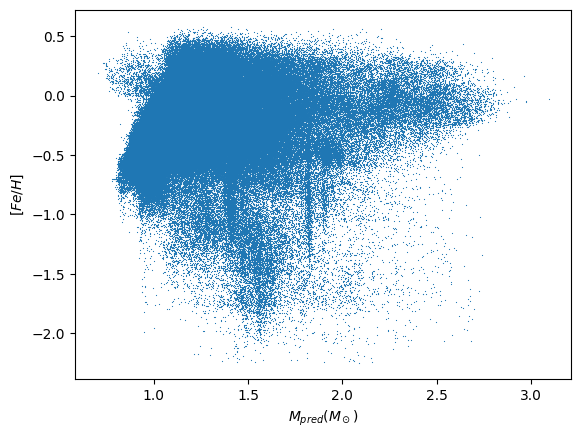

In [48]:
# colors = cm.hot(red_giants_apogee.logg)
plt.plot(red_giants_apogee.mass, red_giants_apogee.fe_h, "x", markersize=0.2)
plt.xlabel("$M_{pred} (M_\odot)$")
plt.ylabel("[$Fe/H$]")